In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import scipy.io
import matplotlib.pyplot as plt
from SNN_JHK_v3_230314_torch import *
from Function.Stimulation_GPU import *
from Function.ReceptiveField_GPU import *
import torch.nn as nn
from Function.plot_SNN import *
import torch
import torch.nn as nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
print("GPU available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

# Enable GPU support if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

GPU available: False
CUDA version: None


In [7]:
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.0.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-10.16-x86_64-i386-64bit


In [3]:
sensor_h, sensor_w = 19, 16 #(mm)
pixel_h, pixel_w = 64, 48
img_FPS = 60

In [4]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_left2right = torch.zeros((pixel_h, pixel_w, num_stim), device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/16
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,r=2)
    stimulation_left2right[:, :, i] = stim_dot

    # if i % 200 == 0:
    #     plt.imshow(stimulation_left2right[:, :, i].cpu(), cmap='jet')
    #     plt.show()


In [5]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_drop = torch.zeros((pixel_h, pixel_w, num_stim),device = device)

F = 20
for i in range(num_stim):
    if i < 500:
        x0 = 8  # Move the stimulus by 0.3mm for each frame
        y0 = 9
    else:
        x0 = 8
        y0 = i*0.3/15
    stim_dot = dot_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,r=2)
    stimulation_drop[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_drop[:, :, i].cpu(), cmap='jet')
    #     plt.show()

In [6]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_0 = torch.zeros((pixel_h, pixel_w, num_stim),device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/16  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w, w=0.5)
    stimulation_angle_0[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_angle_0[:, :, i].cpu(), cmap='jet')
      
    #     plt.show()
        


In [7]:
num_stim = 1000

# Generate the stimuli and stack them up
stimulation_angle_90 = torch.zeros((pixel_h, pixel_w, num_stim),device=device)

F = 10
for i in range(num_stim):
    x0 = i * 0.3/17  # Move the stimulus by 0.3mm for each frame
    y0 = i * 0.3/15
    stim_dot = edge_stim(x0, y0, F=F, pixel_h=pixel_h, pixel_w=pixel_w,theta=np.pi/2,w=0.5)
    stimulation_angle_90[:, :, i] = stim_dot
    # if i % 100 == 0:
    #     plt.imshow(stimulation_angle_90[:, :, i].cpu(), cmap='jet')
    #     plt.colorbar()
    #     plt.show()

In [8]:
num_stim = 1000

# Generate the sequence of F values
max_F = 10
F_array = np.concatenate([
    np.zeros((100,)),
    np.linspace(0, max_F, 200),
    np.full((400,), max_F),
    np.linspace(max_F, 0, 200),
    np.zeros((100,))
])

# Preallocate the stimulation_full array
stimulation_full = torch.zeros((pixel_h, pixel_w, num_stim),device = device)

# Create a color map with a range of 0 to max_F
cmap = plt.cm.get_cmap('jet')
cmap.set_under('k')

# Iterate over F_array and generate the stimuli
for i, F_i in enumerate(F_array):
    stim_dot = full_stim(F=F_i, pixel_h=pixel_h, pixel_w=pixel_w)
    stimulation_full[:, :, i] = stim_dot
    # if i % 200 == 0:
    #     plt.imshow(stimulation_full[:, :, i].cpu(),
    #                cmap=cmap, vmin=0, vmax=max_F)
        
    #     plt.show()
        


c:\Users\JaehunKim\anaconda3\envs\pytorch-CUDA10.1\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))


In [9]:
rf_SA_array = generate_receptivefield()

rf_RA_array = generate_receptivefield(kernel_w=15,kernel_h=15)

receptive_field = [torch.tensor([[5, -2.5], [5, -2.5], [5, -2.5], [5, -2.5], [5, -2.5]], device=device),
                   torch.tensor(
                       [[5,5,5,5,5], [-2.5, -2.5, -2.5, -2.5, -2.5]], device=device),
                   10 * torch.ones((7, 7), device=device)]

receptive_field_noninit = [torch.tensor([[6], [6], [6], [6], [6]], device=device),
                           torch.tensor([[6, 6, 6, 6, 6]], device=device),
                           10 * torch.ones((7, 7), device=device)]

time_delay = [torch.tensor([[5, 1], [5, 1], [5, 1], [5, 1], [5, 1]], device=device),
              torch.tensor([[5, 5, 5, 5, 5], [1, 1, 1, 1, 1]], device=device)]

rf_SA_array_2,rf_SA_length = generate_receptivefield_2(receptive_field,pixel_h=10,
                                                       pixel_w=7,step_size=1)

rf_RA_array_2,rf_RA_length = generate_receptivefield_2(receptive_field,pixel_h=9,
                                                       pixel_w=6,step_size=1)

time_delay_SA = generate_receptivefield_2(time_delay,pixel_h=10,pixel_w=7,step_size=1)



10 7
Complete! Created 10x10 kernel with step size 6! Generated 70 times.
9 6
Complete! Created 15x15 kernel with step size 6! Generated 54 times.
6 6
9 3
4 1
Complete! Generated 67 receptive fields.
5 5
8 2
3 0
Complete! Generated 41 receptive fields.
6 6
9 3
Complete! Generated 63 receptive fields.


layer initialized
layer initialized
layer initialized
layer initialized
0.6142759323120117
tensor([1000., 1120.,  650.,  315.,   30.,    0.,    0.,    0.,    0.,    0.,
         900., 1265., 1195.,  900.,  415.,  155.,    0.,    0.,    0.,    0.,
         495.,  945., 1260., 1210.,  965.,  505.,   95.,    0.,    0.,    0.,
         200.,  515.,  910., 1175., 1155.,  635.,  605.,  105.,    0.,    0.,
           0.,  125.,  370.,  665., 1210., 1265.,  830.,  585.,  210.,    0.,
           0.,    0.,   40.,  325., 1010., 1105., 1140., 1105.,  525.,  315.,
           0.,    0.,    0.,   70.,  320.,  665., 1040., 1300., 1145.,  600.])
tensor([275., 245., 190.,   0.,   0.,   0.,   0.,   0.,   0., 215., 305., 255.,
        155.,  30.,   0.,   0.,   0.,   0.,  55., 225., 260., 285., 135.,  10.,
          0.,   0.,   0.,   0.,  40., 200., 290., 300., 140.,  50.,   0.,   0.,
          0.,   0.,  70., 145., 300., 305., 155.,  55.,   0.,   0.,   0.,   0.,
         50., 140., 305., 325., 175.,  75.

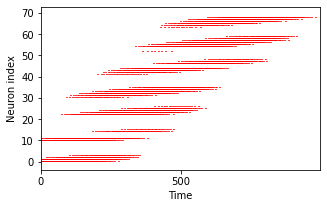

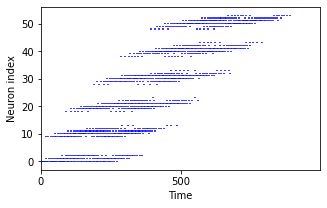

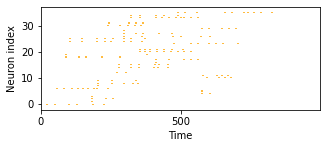

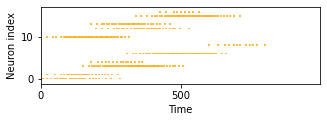

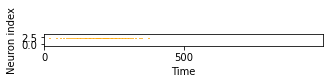

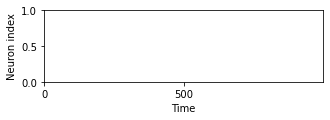

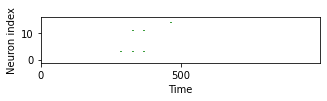

In [23]:
stim = stimulation_left2right.to(device)

input_SA_receptiveField = Synapse(rf_SA_array.to(device))
input_RA_receptiveField = Synapse(rf_RA_array.to(device))

input_SA_receptiveField_2 = Synapse(rf_SA_array_2.to(device))
input_RA_receptiveField_2 = Synapse(rf_RA_array_2.to(device))

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_SA_array),a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array),a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array_2),a_decay=1)

L1_SA_spike_times = torch.zeros((len(rf_SA_array), num_stim-1), device=device)
L1_RA_spike_times = torch.zeros((len(rf_RA_array), num_stim-1), device=device)
L2_SA_spike_times = torch.zeros(
    (len(rf_SA_array_2), num_stim-1), device=device)
L2_RA_spike_times = torch.zeros(
    (len(rf_RA_array_2), num_stim-1), device=device)

start_time = time.time()

for i in range(1,num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        torch.abs(stim[:,:,i]-stim[:,:,i-1]).reshape(-1))*20
    
    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)
    
    
    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(torch.sum(L1_SA_spike_times,axis=1)/0.2)
print(torch.sum(L1_RA_spike_times,axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.6009984016418457
tensor([1000., 1120.,  650.,  315.,   30.,    0.,    0.,    0.,    0.,    0.,
         900., 1265., 1195.,  900.,  415.,  155.,    0.,    0.,    0.,    0.,
         495.,  945., 1260., 1210.,  965.,  505.,   95.,    0.,    0.,    0.,
         200.,  515.,  910., 1175., 1155.,  635.,  605.,  105.,    0.,    0.,
           0.,  125.,  370.,  665., 1210., 1265.,  830.,  585.,  210.,    0.,
           0.,    0.,   40.,  325., 1010., 1105., 1140., 1105.,  525.,  315.,
           0.,    0.,    0.,   70.,  320.,  665., 1040., 1300., 1145.,  600.])
tensor([275., 245., 190.,   0.,   0.,   0.,   0.,   0.,   0., 215., 305., 255.,
        155.,  30.,   0.,   0.,   0.,   0.,  55., 225., 260., 285., 135.,  10.,
          0.,   0.,   0.,   0.,  40., 200., 290., 300., 140.,  50.,   0.,   0.,
          0.,   0.,  70., 145., 300., 305., 155.,  55.,   0.,   0.,   0.,   0.,
         50., 140., 305., 325., 175.,  75.

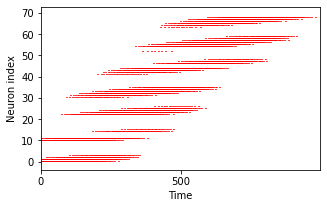

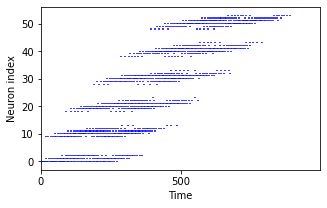

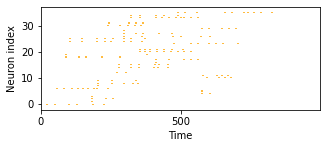

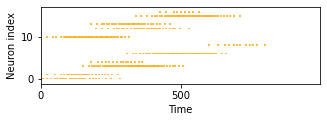

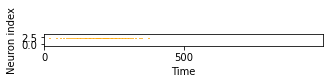

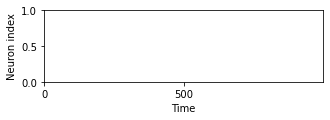

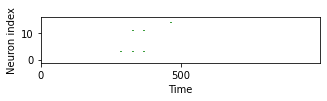

In [11]:
import torch

# Assuming rf_SA_array, rf_RA_array, rf_SA_array_2, and rf_RA_array_2 have been already converted to torch tensors

stim = stimulation_left2right.to(device)

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = torch.zeros((len(rf_SA_array), num_stim-1), device=device)
L1_RA_spike_times = torch.zeros((len(rf_RA_array), num_stim-1), device=device)
L2_SA_spike_times = torch.zeros((len(rf_SA_array_2), num_stim-1), device=device)
L2_RA_spike_times = torch.zeros((len(rf_RA_array_2), num_stim-1), device=device)

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].view(-1)) * 2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        torch.abs(stim[:, :, i] - stim[:, :, i - 1]).view(-1)) * 20

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(torch.sum(L1_SA_spike_times, axis=1) / 0.2)
print(torch.sum(L1_RA_spike_times, axis=1) / 0.2)
plot_spike_times(L1_SA_spike_times.cpu(), 'r', size=(5, 3))
plot_spike_times(L1_RA_spike_times.cpu(), 'b')
plot_spike_times(L2_SA_spike_times[0:36].cpu(), 'orange', size=(5, 3*36/57))
plot_spike_times(L2_SA_spike_times[36:53].cpu(), 'orange', size=(5, 3*27/57))
plot_spike_times(L2_SA_spike_times[53:57].cpu(), 'orange', size=(5, 3*4/57))
plot_spike_times(L2_RA_spike_times[0:25].cpu(), 'g', size=(5, 3*25/57))
plot_spike_times(L2_RA_spike_times[25:41].cpu(), 'g', size=(5, 3*16/57))


layer initialized
layer initialized
layer initialized
layer initialized
0.6030008792877197
[1000. 1120.  650.  315.   30.    0.    0.    0.    0.    0.  900. 1265.
 1195.  900.  415.  155.    0.    0.    0.    0.  495.  945. 1260. 1210.
  965.  505.   95.    0.    0.    0.  200.  515.  910. 1175. 1155.  635.
  605.  105.    0.    0.    0.  125.  370.  665. 1210. 1265.  830.  585.
  210.    0.    0.    0.   40.  325. 1010. 1105. 1140. 1105.  525.  315.
    0.    0.    0.   70.  320.  665. 1040. 1300. 1145.  600.]
[755. 845. 785. 245.  30.   0.   0.   0.   0. 760. 895. 870. 730. 380.
  20.   0.   0.   0. 480. 800. 885. 920. 685. 315. 100.   0.   0.  15.
 465. 815. 890. 950. 685. 450. 135.   0.   0.  65. 495. 710. 905. 930.
 735. 460.  95.   0.   0.  60. 455. 695. 905. 920. 765. 470.]


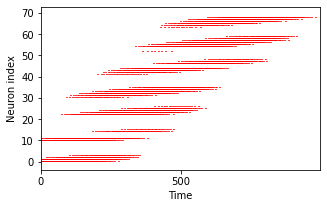

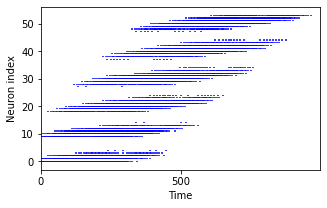

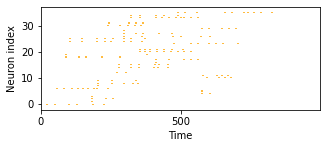

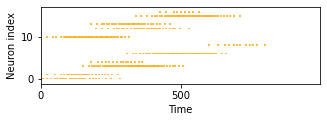

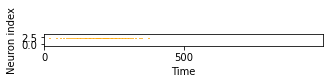

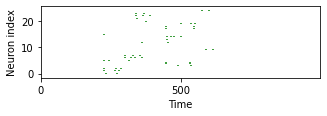

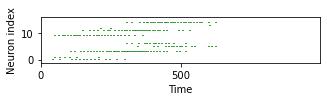

In [12]:
stim = stimulation_left2right

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_SA_array),a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array),a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8,len(rf_RA_array_2),a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1,num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100
    
    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)
    
    
    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times,axis=1)/0.2)
print(np.sum(L1_RA_spike_times,axis=1)/0.2)
plot_spike_times(L1_SA_spike_times, 'r', size=(5, 3))
plot_spike_times(L1_RA_spike_times, 'b')
plot_spike_times(L2_SA_spike_times[0:36], 'orange', size=(5, 3*36/57))
plot_spike_times(L2_SA_spike_times[36:53], 'orange', size=(5, 3*27/57))
plot_spike_times(L2_SA_spike_times[53:57], 'orange', size=(5, 3*4/57))
plot_spike_times(L2_RA_spike_times[0:25], 'g', size=(5, 3*25/57))
plot_spike_times(L2_RA_spike_times[25:41], 'g', size=(5, 3*16/57))


layer initialized
layer initialized
layer initialized
layer initialized
0.6000053882598877
[675. 710. 705. 720. 615. 655. 720. 745. 705. 740. 640. 785. 660. 715.
 750. 760. 735. 625. 645. 795. 665. 690. 760. 795. 705. 730. 670. 680.
 735. 750. 655. 695. 700. 685. 665. 640. 805. 655. 730. 710. 750. 705.
 675. 665. 675. 660. 680. 760. 730. 700. 670. 745. 670. 655. 725. 680.
 670. 765. 740. 820. 700. 760. 860. 785. 720. 740. 660. 760. 775. 690.]
[515. 665. 740. 470. 490. 720. 645. 770. 680. 555. 635. 515. 660. 540.
 570. 690. 610. 760. 660. 710. 470. 530. 515. 595. 605. 640. 600. 495.
 730. 615. 620. 620. 505. 565. 630. 565. 680. 610. 725. 670. 665. 650.
 575. 695. 455. 645. 595. 695. 810. 630. 680. 625. 575. 505.]


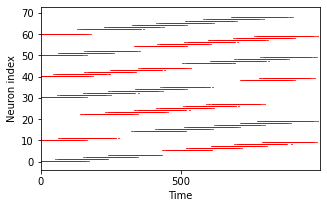

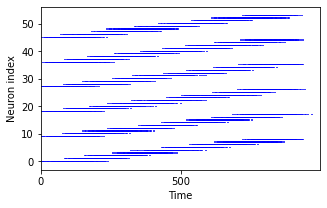

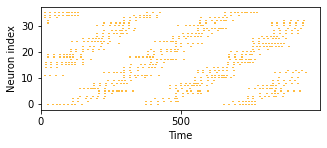

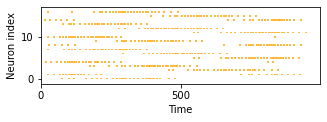

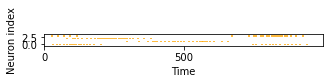

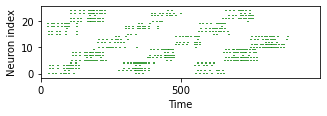

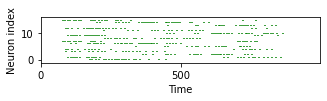

In [13]:
stim = stimulation_angle_0

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*4
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*60

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.6260063648223877
[ 775.  800.  905.  745.  740.  750.  780.  900.  795.  820.  825.  855.
  925.  850.  860.  860.  905.  795.  860.  830.  820.  880.  840.  850.
  880.  930.  760.  790.  860.  730.  860.  940.  930.  850.  795.  705.
  975.  950.  885.  860.  825.  800.  920.  845.  895. 1010.  795.  865.
  970.  770. 1065.  910.  750.  815.  920.  825.  715.  885.  850.  880.
  770.  800.  890.  915.  855.  930.  815.  860.  885.  850.]
[1005.  960. 1035.  800.  855. 1030.  900. 1110.  935.  945. 1000.  835.
 1085.  940.  965.  945.  905. 1060.  980. 1030.  825.  980.  885.  920.
  995.  960.  925.  890. 1005.  915.  980. 1050.  745.  880.  950.  930.
 1140.  940. 1130. 1045. 1005. 1110.  915. 1020.  605. 1035.  920.  965.
 1045.  980.  965.  990.  940.  870.]


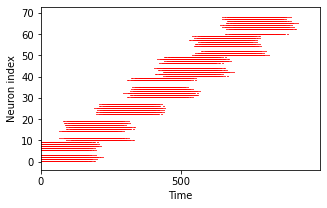

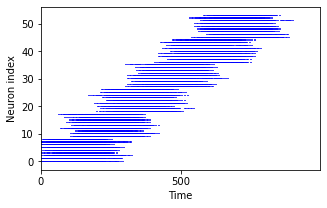

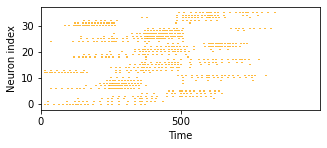

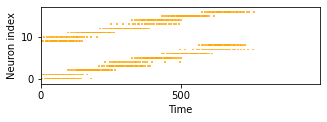

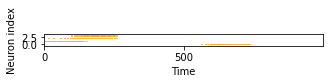

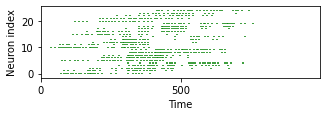

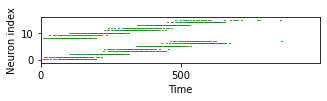

In [14]:
stim = stimulation_angle_90

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)

input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*4
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))

layer initialized
layer initialized
layer initialized
layer initialized
0.5980067253112793
[3430. 3490. 3450. 3440. 3410. 3390. 3440. 3580. 3435. 3560. 3400. 3510.
 3500. 3515. 3580. 3510. 3550. 3405. 3345. 3500. 3430. 3390. 3500. 3460.
 3530. 3520. 3350. 3340. 3480. 3415. 3520. 3550. 3450. 3415. 3400. 3325.
 3580. 3430. 3570. 3410. 3530. 3465. 3450. 3345. 3440. 3500. 3380. 3525.
 3540. 3350. 3530. 3550. 3255. 3330. 3580. 3405. 3350. 3520. 3340. 3550.
 3355. 3480. 3540. 3520. 3470. 3525. 3330. 3530. 3505. 3455.]
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.]


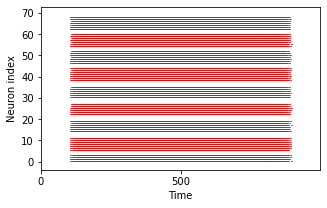

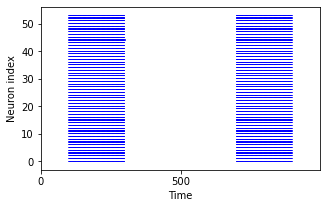

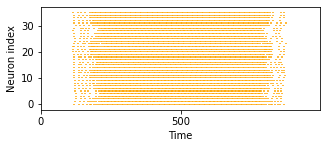

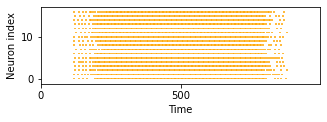

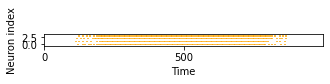

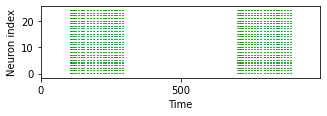

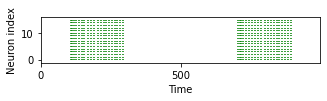

In [15]:
stim = stimulation_full

input_SA_receptiveField = Synapse(rf_SA_array)
input_RA_receptiveField = Synapse(rf_RA_array)

input_SA_receptiveField_2 = Synapse(rf_SA_array_2)
input_RA_receptiveField_2 = Synapse(rf_RA_array_2)

L1_SA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_SA_array), a_decay=1.01)
L1_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array), a_decay=1)
L2_SA = IzhikevichLayer(0.1, 0.2, -65, 6, len(rf_SA_array_2), a_decay=1.01)
L2_RA = IzhikevichLayer(0.02, 0.2, -65, 8, len(rf_RA_array_2), a_decay=1)

L1_SA_spike_times = np.zeros((len(rf_SA_array), num_stim-1))
L1_RA_spike_times = np.zeros((len(rf_RA_array), num_stim-1))
L2_SA_spike_times = np.zeros((len(rf_SA_array_2), num_stim-1))
L2_RA_spike_times = np.zeros((len(rf_RA_array_2), num_stim-1))

start_time = time.time()

for i in range(1, num_stim):
    SA_receptive_input = input_SA_receptiveField.cal_post_input(
        stim[:, :, i].reshape(-1))*2
    RA_receptive_input = input_RA_receptiveField.cal_post_input(
        np.abs(stim[:, :, i] - stim[:, :, i - 1]).reshape(-1))*100

    L1_SA.update(SA_receptive_input)
    L1_RA.update(RA_receptive_input)

    SA_receptive_input_2 = input_SA_receptiveField_2.cal_post_input(
        L1_SA.spikes)
    RA_receptive_input_2 = input_RA_receptiveField_2.cal_post_input(
        L1_RA.spikes)

    L2_SA.update(SA_receptive_input_2)
    L2_RA.update(RA_receptive_input_2)

    L1_SA_spike_times[:, i-1] = L1_SA.spikes
    L1_RA_spike_times[:, i-1] = L1_RA.spikes
    L2_SA_spike_times[:, i-1] = L2_SA.spikes
    L2_RA_spike_times[:, i-1] = L2_RA.spikes

print
end_time = time.time()

vectorized_time = end_time - start_time

print(vectorized_time)
print(np.sum(L1_SA_spike_times, axis=1)/0.2)
print(np.sum(L1_RA_spike_times, axis=1)/0.2)
plot_spike_times(L1_SA_spike_times,'r',size = (5,3))
plot_spike_times(L1_RA_spike_times,'b')
plot_spike_times(L2_SA_spike_times[0:36],'orange',size = (5,3*36/57))
plot_spike_times(L2_SA_spike_times[36:53],'orange',size = (5,3*27/57))
plot_spike_times(L2_SA_spike_times[53:57],'orange',size = (5,3*4/57))
plot_spike_times(L2_RA_spike_times[0:25],'g',size = (5,3*25/57))
plot_spike_times(L2_RA_spike_times[25:41],'g',size = (5,3*16/57))


In [16]:
receptive_field = [np.array([[5,-2],[5,-2],[5,-2],[5,-2],[5,-2]]),np.array([[5,5,5,5,5],[-2,-2,-2,-2,-2]])]

receptive_field_time_delay = [np.array([[5, 1], [5, 1], [5, 1], [5, 1], [5, 1]]),
                   np.array([[5, 5, 5, 5, 5], [1,1,1,1,1]])]

rf_SA_array_2_time_delay = generate_receptivefield_2(
    receptive_field_time_delay, pixel_h=10, pixel_w=7, step_size=1)




6 6


TypeError: can't assign a numpy.ndarray to a torch.FloatTensor

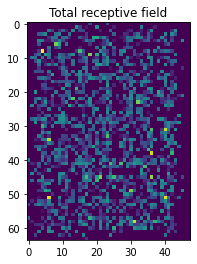

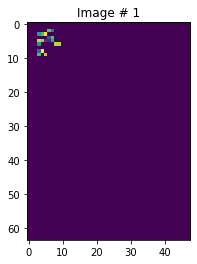

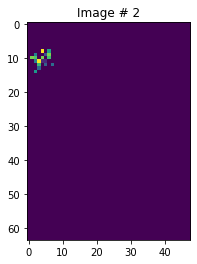

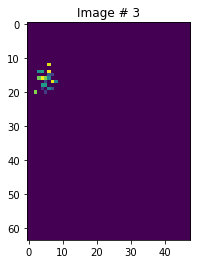

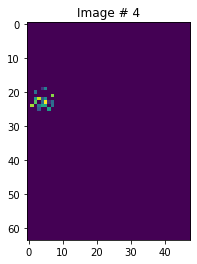

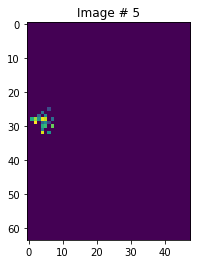

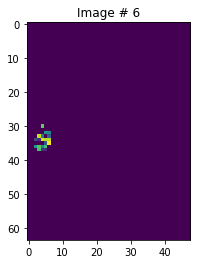

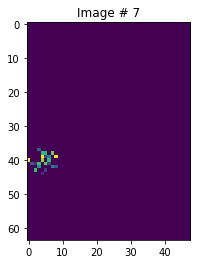

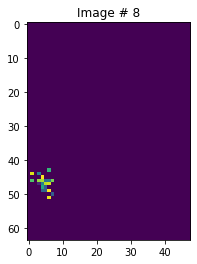

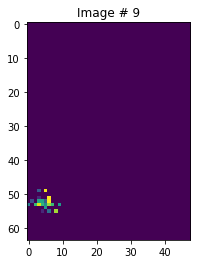

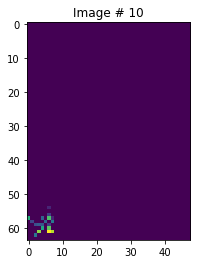

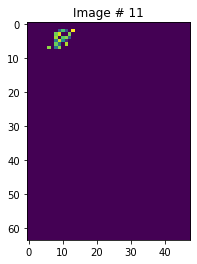

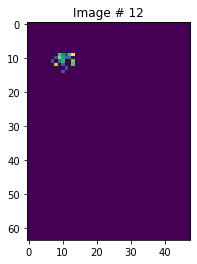

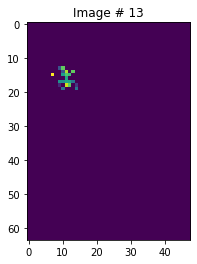

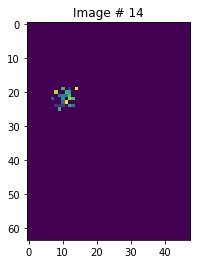

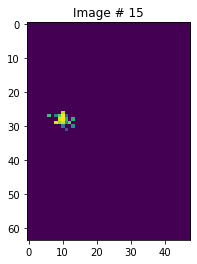

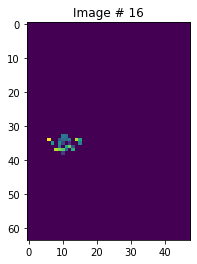

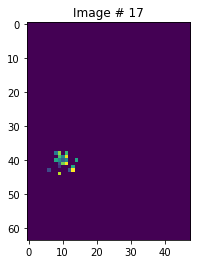

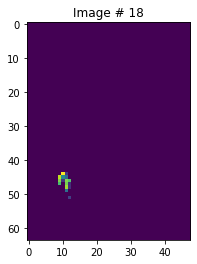

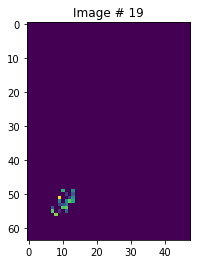

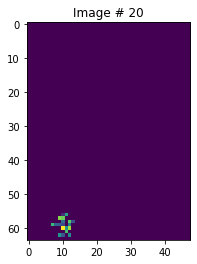

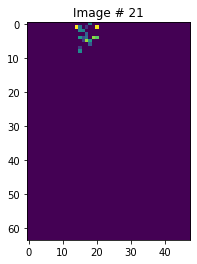

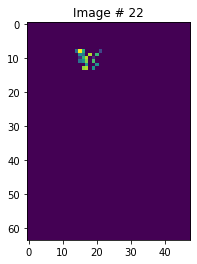

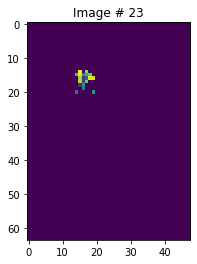

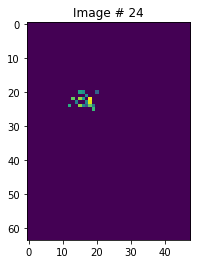

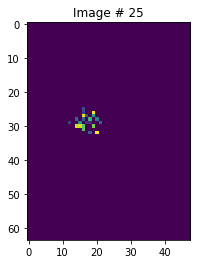

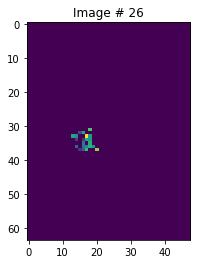

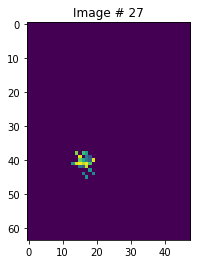

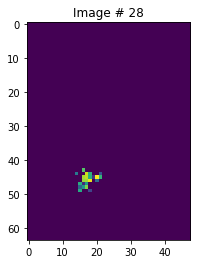

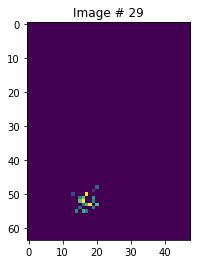

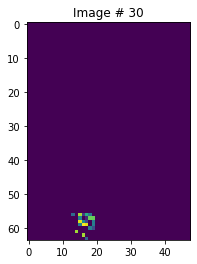

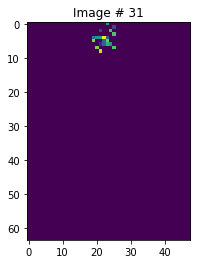

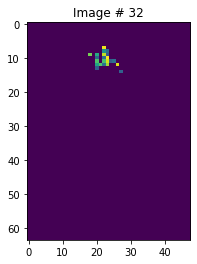

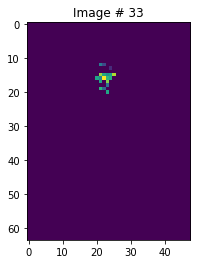

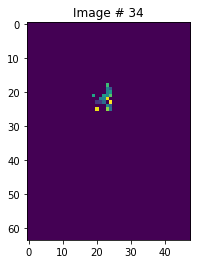

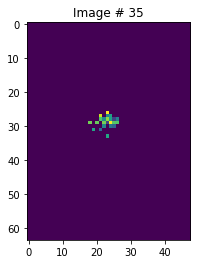

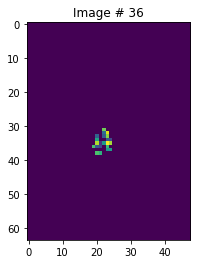

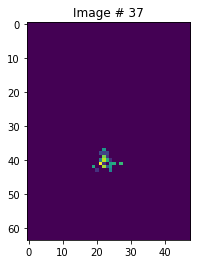

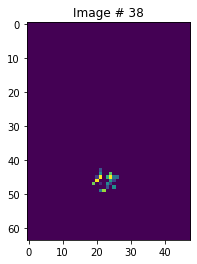

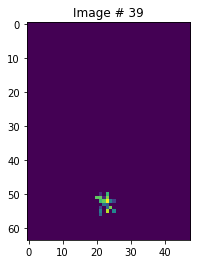

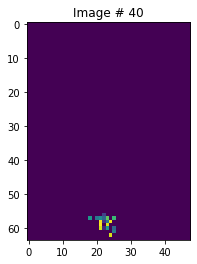

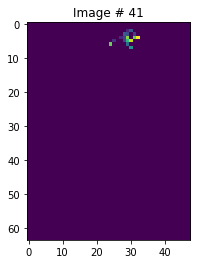

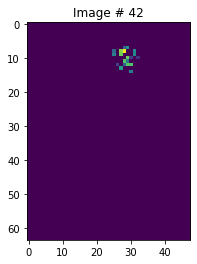

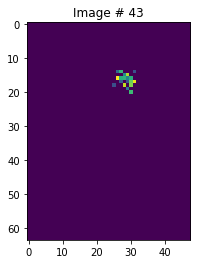

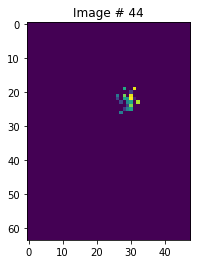

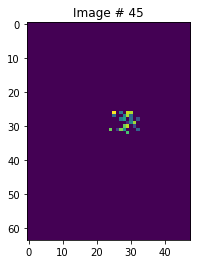

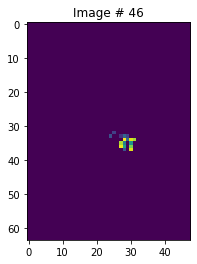

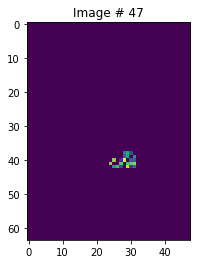

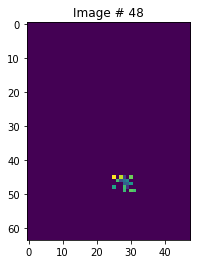

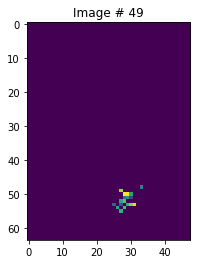

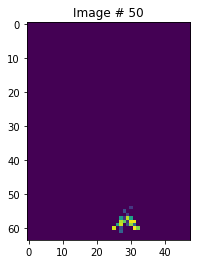

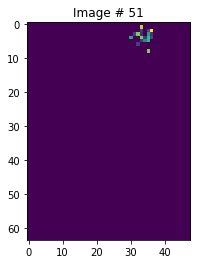

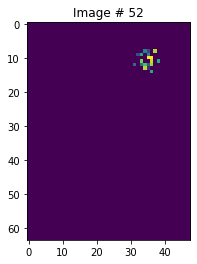

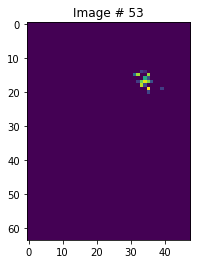

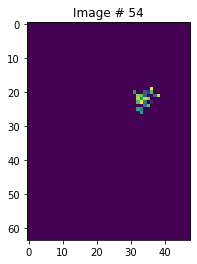

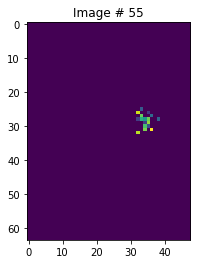

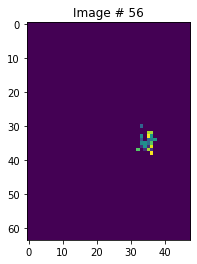

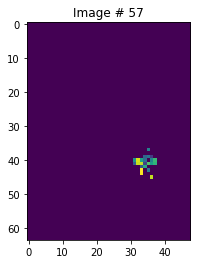

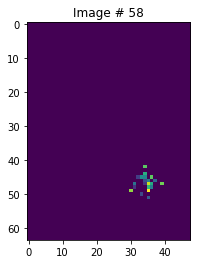

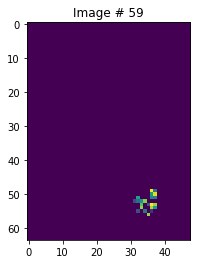

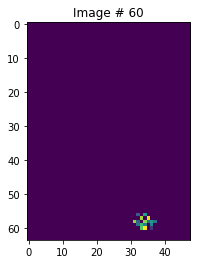

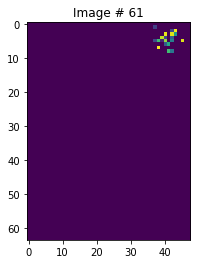

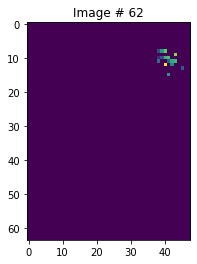

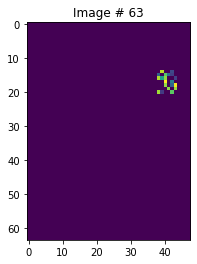

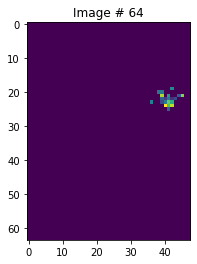

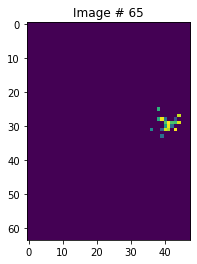

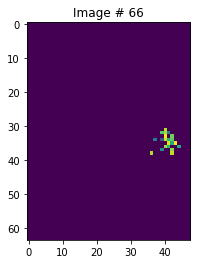

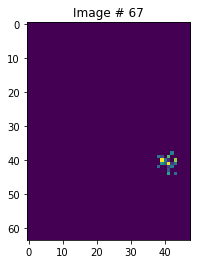

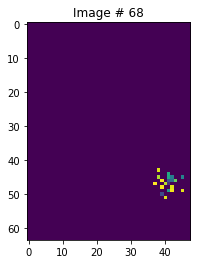

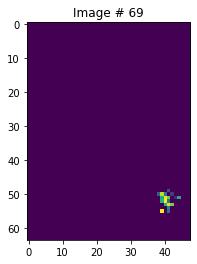

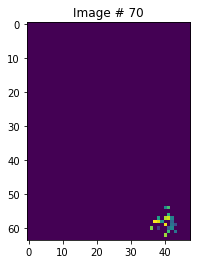

In [ ]:
plt.figure()
plt.imshow(np.sum(rf_SA_array,axis=0).reshape(pixel_h, pixel_w), cmap='viridis')
plt.title('Total receptive field')
plt.show()


for i in range(len(rf_SA_array)):
    plt.figure()
    plt.imshow(rf_SA_array[i].reshape(pixel_h, pixel_w), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()


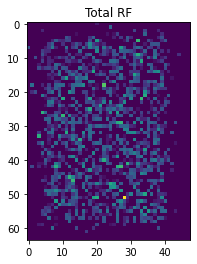

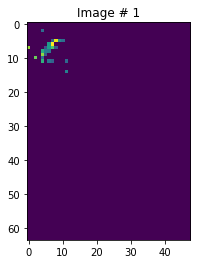

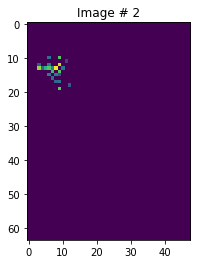

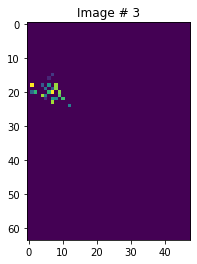

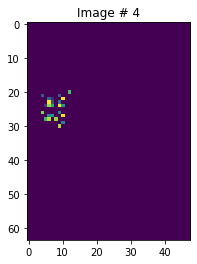

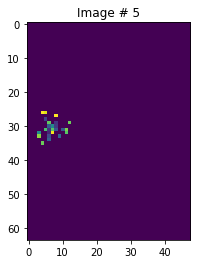

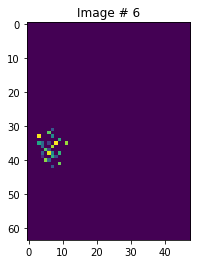

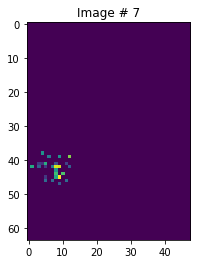

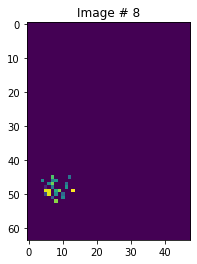

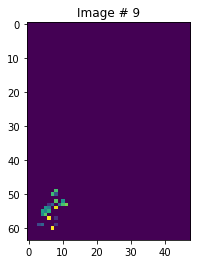

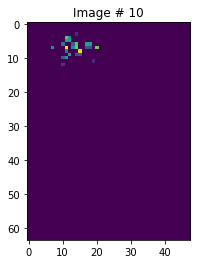

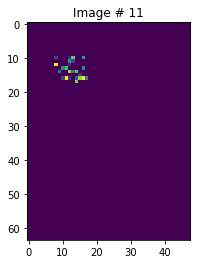

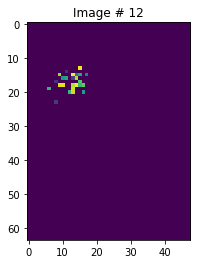

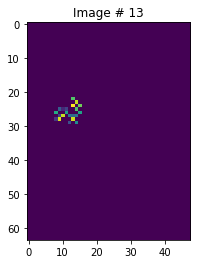

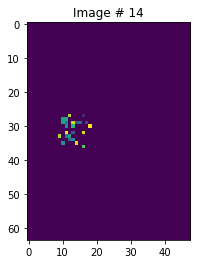

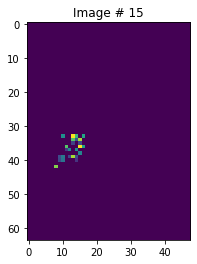

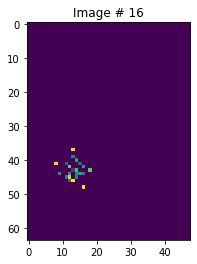

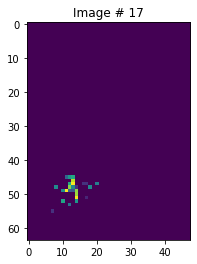

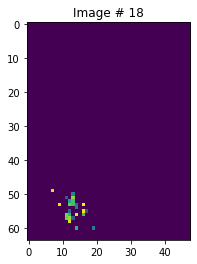

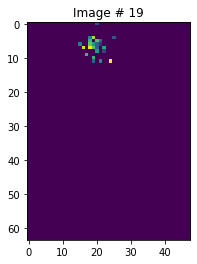

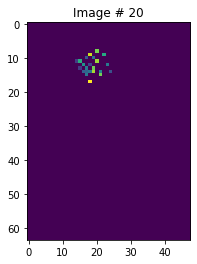

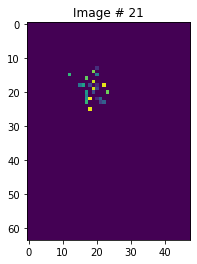

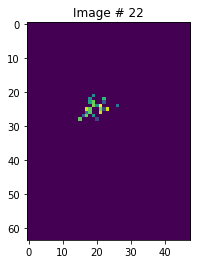

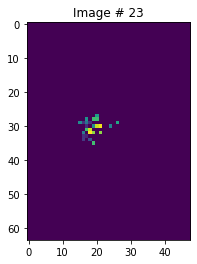

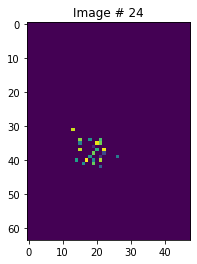

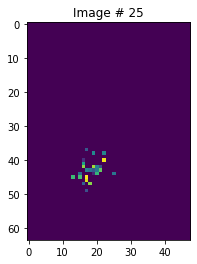

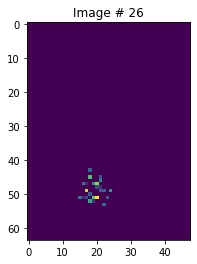

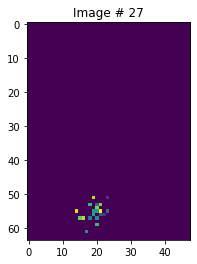

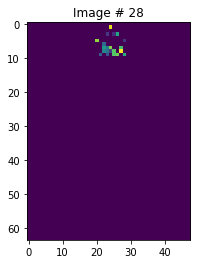

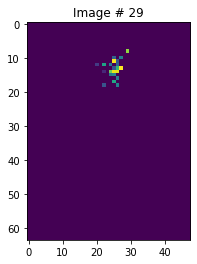

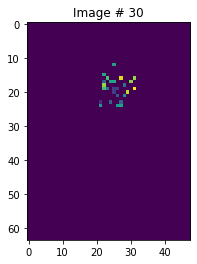

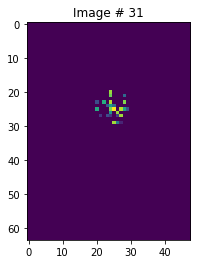

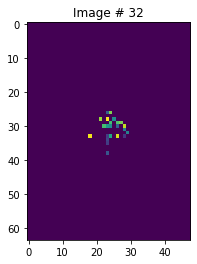

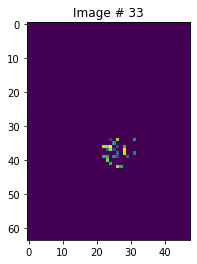

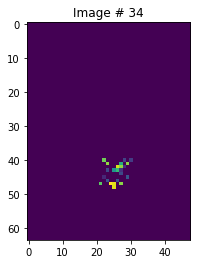

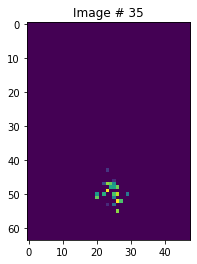

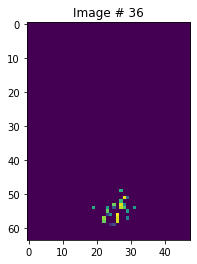

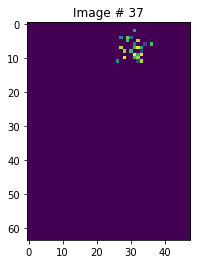

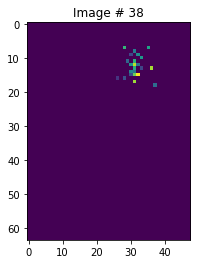

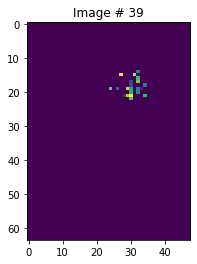

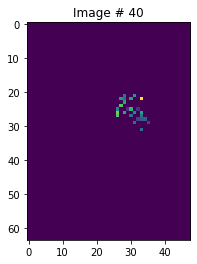

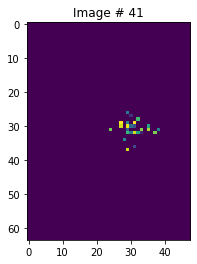

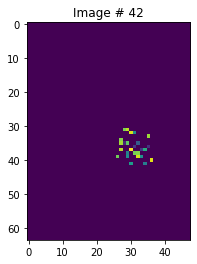

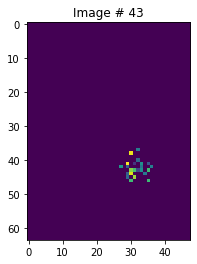

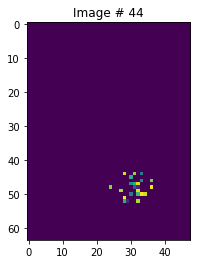

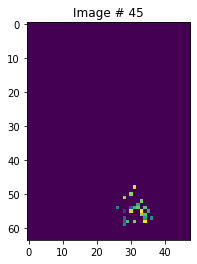

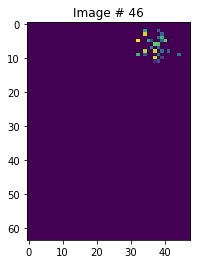

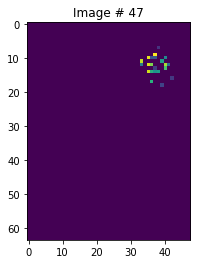

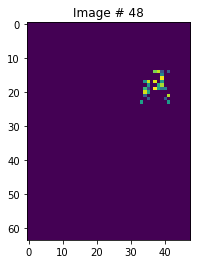

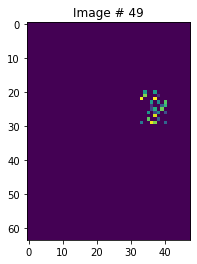

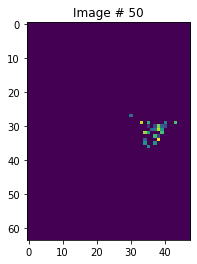

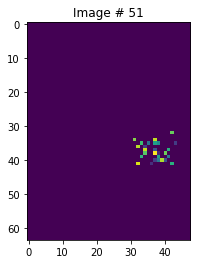

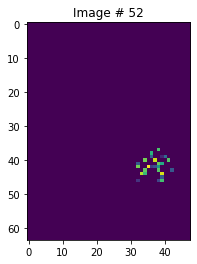

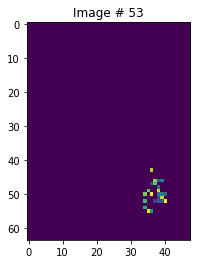

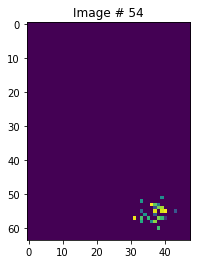

In [ ]:
plt.figure()
plt.imshow(np.sum(rf_RA_array,axis=0).reshape(pixel_h, pixel_w), cmap='viridis')
plt.title('Total RF')
plt.show()

for i in range(len(rf_RA_array)):
    plt.figure()
    plt.imshow(rf_RA_array[i].reshape(pixel_h, pixel_w), cmap='viridis')
    plt.title('Image # {}'.format(i+1))
    plt.show()



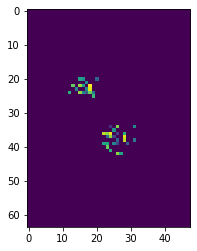

In [ ]:
tmp_array = rf_SA_array[23] + rf_RA_array[32]


plt.figure()
plt.imshow(tmp_array.reshape(
    pixel_h, pixel_w), cmap='viridis')
plt.show()
